# LGPA 2022 ~ 2024 data crawing
### 프로젝트 기간 (2024-04-19 ~ )
### written by 류홍규

In [64]:
from IPython.display import Image

## 목적: LGPA 프로 선수들의 스탯을 분석하여 비교
### 기준점: Driving Accuracy
- Driving Accuracy Top선수들의 선수별 세부 Stats를 수집

### 선수들의 세부 Stats 수집 지표
| Category                |                        |
|-------------------------|------------------------|
| Average Driving Distance| 드라이빙 거리(파4홀과 파5홀 티샷친 평균거리)
| Driving Accuracy        | 드라이빙 정확도(파4, 파5홀에서 티샷을 페어웨이에 떨어진 것을 측정)
| Greens in Regulation    | 그린 적중률(티샷 후 그린에 공이 올라간 것)
| Putts Per GIR           | 퍼팅수 / 그린 적중률 (낮을 수록 좋은 것)
| Putting Average         | 평균 퍼팅 수
| Sand Saves              | 벙커에서 첫번째 샷 후 그린에 성공적으로 공을 놓을 확률
| Scoring Average         | 한 라운드(18홀)에서 평균적으로 치는 점수
| Rounds Under Par        | 파보다 낮은 점수로 라운드를 마친 횟수
| Total Rounds Played     | 선수가 대회중에 참여한 총 라운드 수

- eagle의 경우 잘 안 나오기도 하며, 일반인들은 eagle은 나오기가 힘드니 배제했다.
### 수집이 너무 오래 걸리는 현상 (해결)
```python
concurrent.futures.ThreadPoolExecutor
```
- I/O 바운드 작업에서 성능이 향상되며, 병렬 처리를 통해 기존 10분 이상에서 37초로 시간을 단축하였습니다.
- 다만, Python은 GIL(Global Interpreter Lock) 때문에 CPU-bound 작업의 병렬 처리에 한계가 있어, ProcessPoolExecutor를 사용하는 것도 좋은 방법이라 생각합니다.
- GIL은 한번에 하나의 스레드만 Python바이트코드를 실행할 수 있는 반면, 고성능 CPU에서는 ProcessPoolExecutor를 사용하면, 별도의 프로세스를 사용하여 병렬처리를 구현하기 때문에, 효과적으로 처리할 수 있기 때문입니다. 

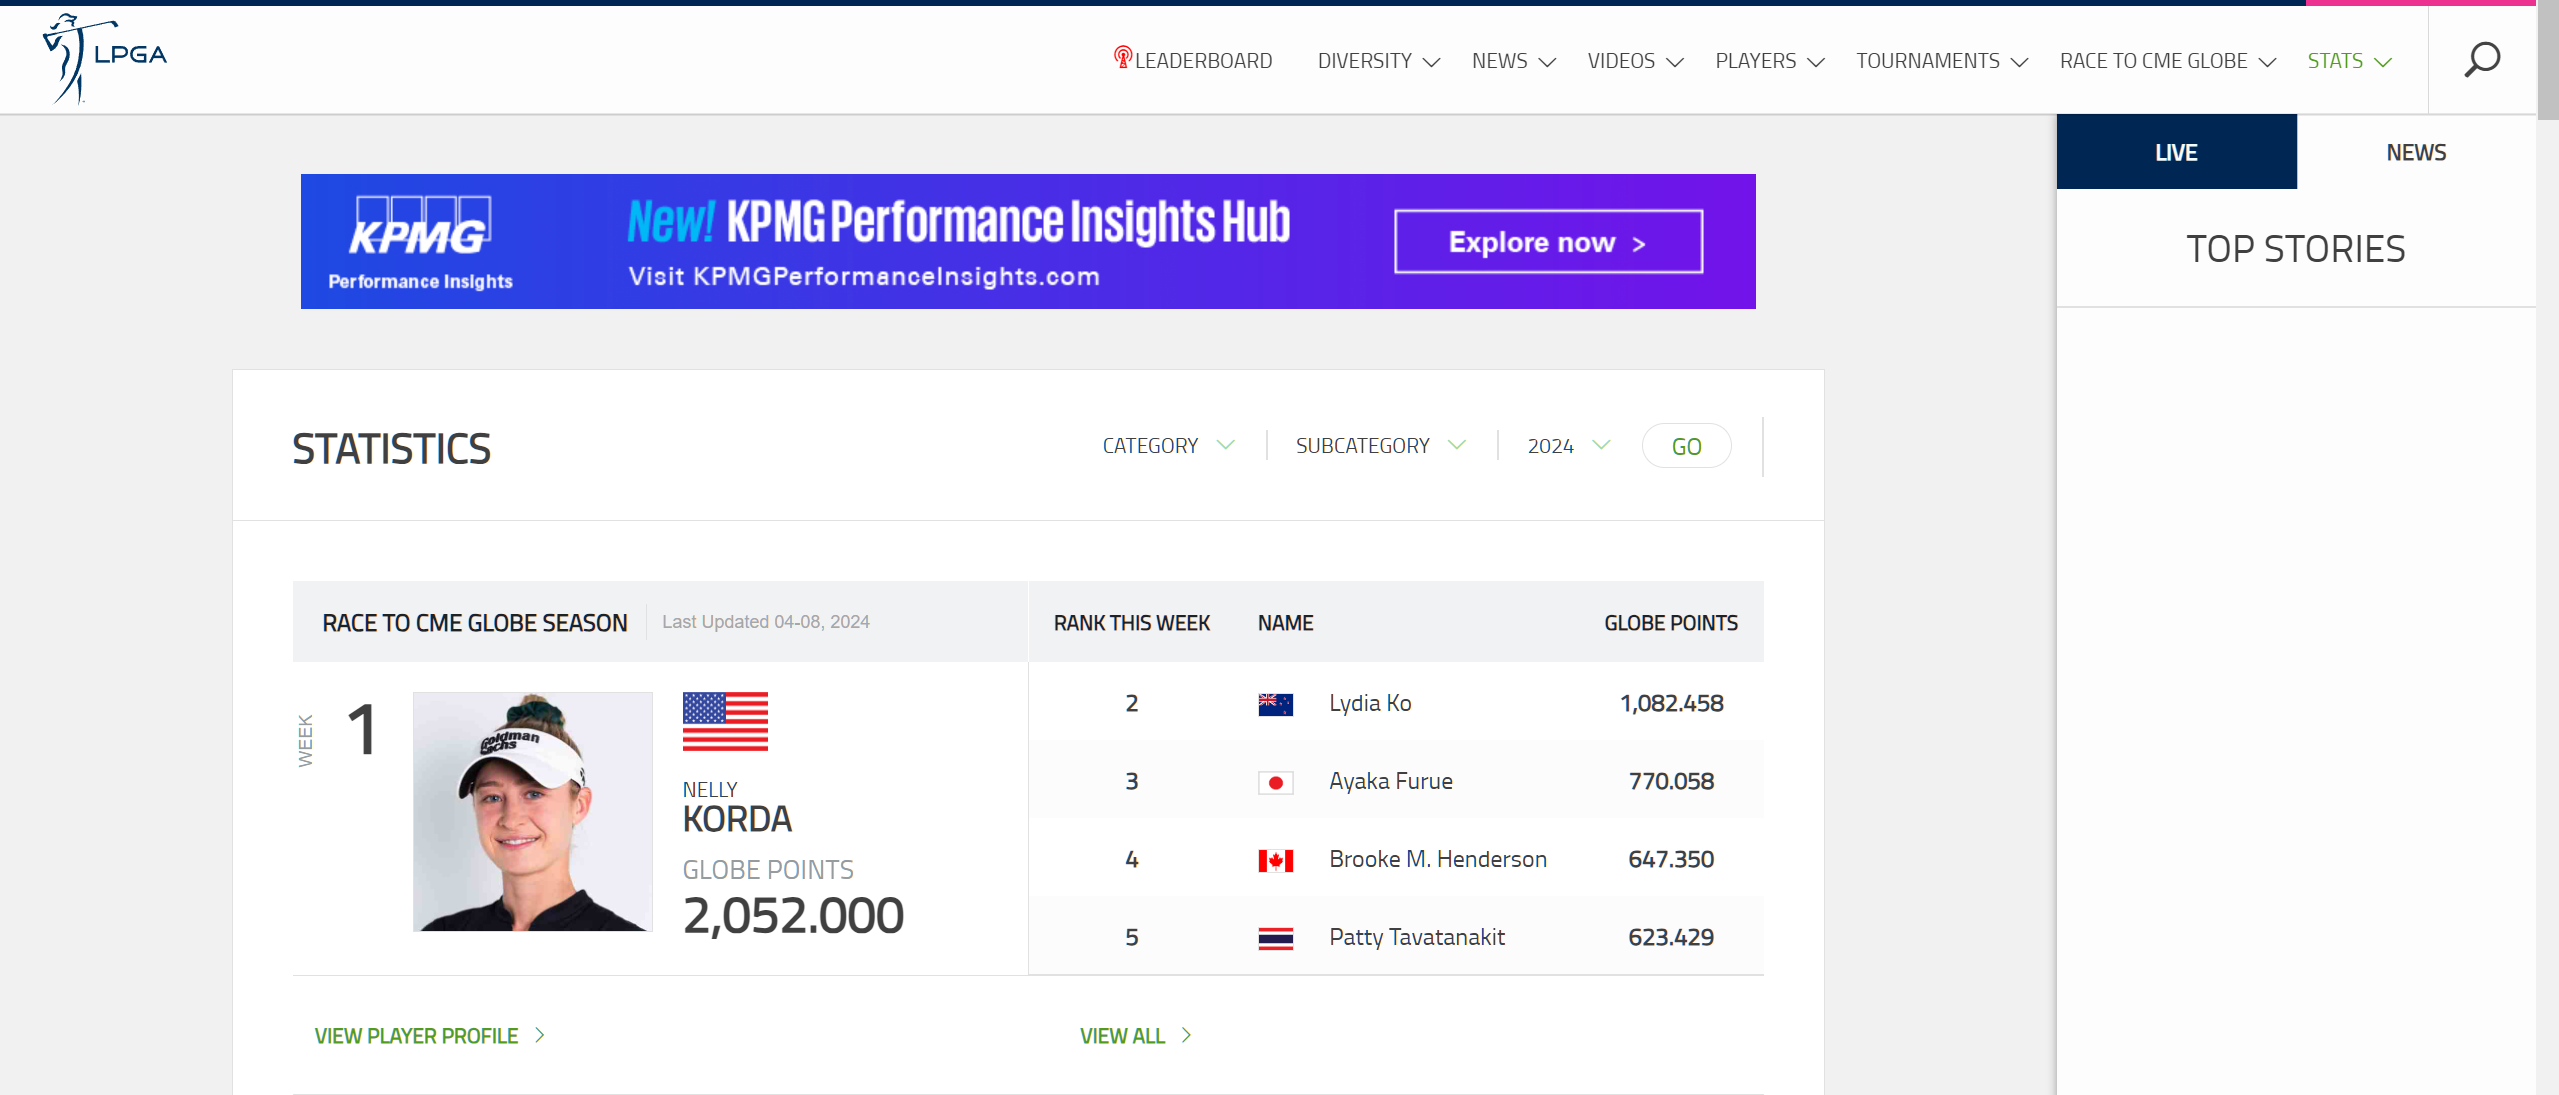

In [73]:
image_path = "C:\\Users\\minsu\\Downloads\\image_to_jupyter\\first_image.png"

Image(filename=image_path)

In [74]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor #속도 개선용
from tqdm import tqdm

In [75]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# url로부터 country 찾기
def extract_country_from_url(url):
    start_idx = url.find('countries/') + len('countries/')
    end_idx = url.rfind('.')
    return url[start_idx:end_idx]

# 상세 players의 stats 크롤링
def players_stats(player_url):
    response = requests.get(player_url)
    if response.status_code != 200:
        print("잘못된 접근입니다.")
        return None
    soup = BeautifulSoup(response.content, 'html.parser')
    
    stats_dict = {}
    
    stats_to_find = [
        'Average Driving Distance', 'Driving Accuracy', 
        'Greens in Regulation', 'Putts per GIR', 
        'Putting Average', 'Sand Saves', 
        'Scoring Average', 'Rounds Under Par', 'Total Rounds Played'
    ]
    
    rows = soup.find_all('tr', class_='body')
    
    for row in rows:
        header = row.find('td', class_='table-content left')
        if header.text.strip() in stats_to_find:
            value_td = row.find_all('td', class_='table-content')
            
            if len(value_td) == 3:
                value = value_td[1].text.strip()
                rank = value_td[2].text.strip()
                
                stats_dict[header.text.strip()] = {'Value': value, 'Rank': rank}
    
    return stats_dict

# 중간 점검.
#players_stats('https://www.lpga.com/players/lizette-salas/88510/stats')
# <Response [200]>
#############################################################################
# {'Average Driving Distance': {'Value': '236.69', 'Rank': '150'},
#  'Driving Accuracy': {'Value': '88.39%', 'Rank': '1'},
#  'Greens in Regulation': {'Value': '62.50%', 'Rank': '121'},
#  'Putts per GIR': {'Value': '1.76', 'Rank': '27'},
#  'Putting Average': {'Value': '28.25', 'Rank': '8'},
#  'Sand Saves': {'Value': '56.25%', 'Rank': '16'},
#  'Scoring Average': {'Value': '70.50', 'Rank': '26'},
#  'Rounds Under Par': {'Value': '5', 'Rank': '87'},
#  'Total Rounds Played': {'Value': '8', 'Rank': '130'}}
    
##############################################################################


# 병렬 처리로 크롤링
def lgpa_data_parallel(statistic, category, year):
    url = f"https://www.lpga.com/statistics/{statistic}/{category}?year={year}"
    response =  requests.get(url)
    if response.status_code != 200:
        print("사이트가 응답하지 않습니다.")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    tbody = soup.find('tbody')
    rows = tbody.find_all('tr', class_='body')
    
    data_lists = []
    
    player_urls = [f"https://www.lpga.com{row.find('a')['href'].replace('/overview', '/stats')}" for row in rows]
    
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(players_stats, player_urls))
        
        for row, player_stats in zip(rows, results):
            columns = row.find_all('td', class_='table-content')
            img_src = columns[1].find('img')['src']
            player_name = columns[1].text.strip()
            country = extract_country_from_url(img_src)
            
            if player_stats:
                data_list = {
                    'Country': country,
                    'Year': year,
                    'Player Name': player_name,
                }
                
                for stat, values in player_stats.items():
                    data_list[f"{stat}"] = values['Value']
                    data_list[f"{stat}_rank"] = values['Rank']
                    
                data_lists.append(data_list)
    
    df = pd.DataFrame(data_lists)
    
    return df

# 중간점검
df = lgpa_data_parallel('driving', 'driving-accuracy', '2024')
print(df.head())


  Country  Year     Player Name Average Driving Distance  \
0     usa  2024   Lizette Salas                   236.69   
1     usa  2024     Marina Alex                   242.71   
2     jpn  2024     Ayaka Furue                   249.29   
3     usa  2024  Allisen Corpuz                   243.67   
4     ger  2024    Olivia Cowan                   251.07   

  Average Driving Distance_rank Driving Accuracy Driving Accuracy_rank  \
0                           150           88.39%                     1   
1                           146           87.39%                     2   
2                           126           86.64%                     3   
3                           142           86.51%                     4   
4                           119           85.71%                     5   

  Greens in Regulation Greens in Regulation_rank Putts per GIR  ...  \
0               62.50%                       121          1.76  ...   
1               70.26%                        41    

In [80]:
import time


# 시작 시간
start_time = time.time()


# 3개년
years = ['2022', '2023', '2024']

dfs = []

for year in years:
    with tqdm(desc=f"현재 {year}를 처리중에 있습니다.", position=0, leave=True) as pbar:
        df = lgpa_data_parallel('driving', 'driving-accuracy', year)
        if df is not None:
            dfs.append(df)
        pbar.set_description(f"현재 {year}를 처리중에 있습니다.")


final_data = pd.concat(dfs, ignore_index=True)

final_data.head()

# 총 걸린 시간 출력
end_time = time.time()
elapsed_time = end_time - start_time
print(f"총 걸린 시간: {elapsed_time:.2f}초")

현재 2022를 처리중에 있습니다.: : 0it [00:19, ?it/s]
현재 2023를 처리중에 있습니다.: : 0it [00:09, ?it/s]
현재 2024를 처리중에 있습니다.: : 0it [00:09, ?it/s]

총 걸린 시간: 38.76초


## 수집된 데이터 전처리

In [78]:
# final_data 전체 데이터 shape
final_data.shape

(473, 21)

### 형 변환

In [98]:
# 해당 데이터에 컬럼 type 변경
# rank가 '-'는 순위권 밖이라는 뜻.

import math


test = final_data.copy()
# Year
test['Year'] = pd.to_datetime(test['Year'])

# Average Driving Distance
test['Average Driving Distance'] = test['Average Driving Distance'].astype(float)

# Driving Accuracy
test['Driving Accuracy'] = test['Driving Accuracy'].str.rstrip('%').astype(float) * 0.01
test['Driving Accuracy'] = test['Driving Accuracy'].apply(lambda x: math.floor(x * 1000) / 1000)

# Greens in Regulation
test['Greens in Regulation'] = test['Greens in Regulation'].str.rstrip('%').astype(float) * 0.01
test['Greens in Regulation'] = test['Greens in Regulation'].apply(lambda x: math.floor(x * 1000)/1000)

# Putts per GIR
test['Putts per GIR'] = test['Putts per GIR'].astype(float)

# Putting Average
test['Putting Average'] = test['Putting Average'].astype(float)

# Sand Saves
test['Sand Saves'] = test['Sand Saves'].str.rstrip('%').astype(float) * 0.01
test['Sand Saves'] = test['Sand Saves'].apply(lambda x: math.floor(x * 1000) / 1000)

# Scoring Average
test['Scoring Average'] = test['Scoring Average'].astype(float)

# Rounds Under Par
test['Rounds Under Par'] = test['Rounds Under Par'].astype(int)

# Total Rounds Played
test['Total Rounds Played'] = test['Total Rounds Played'].astype(int)

In [100]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Country                        473 non-null    object        
 1   Year                           473 non-null    datetime64[ns]
 2   Player Name                    473 non-null    object        
 3   Average Driving Distance       473 non-null    float64       
 4   Average Driving Distance_rank  473 non-null    object        
 5   Driving Accuracy               473 non-null    float64       
 6   Driving Accuracy_rank          473 non-null    object        
 7   Greens in Regulation           473 non-null    float64       
 8   Greens in Regulation_rank      473 non-null    object        
 9   Putts per GIR                  473 non-null    float64       
 10  Putts per GIR_rank             473 non-null    object        
 11  Putting Average    

### 이상치 처리

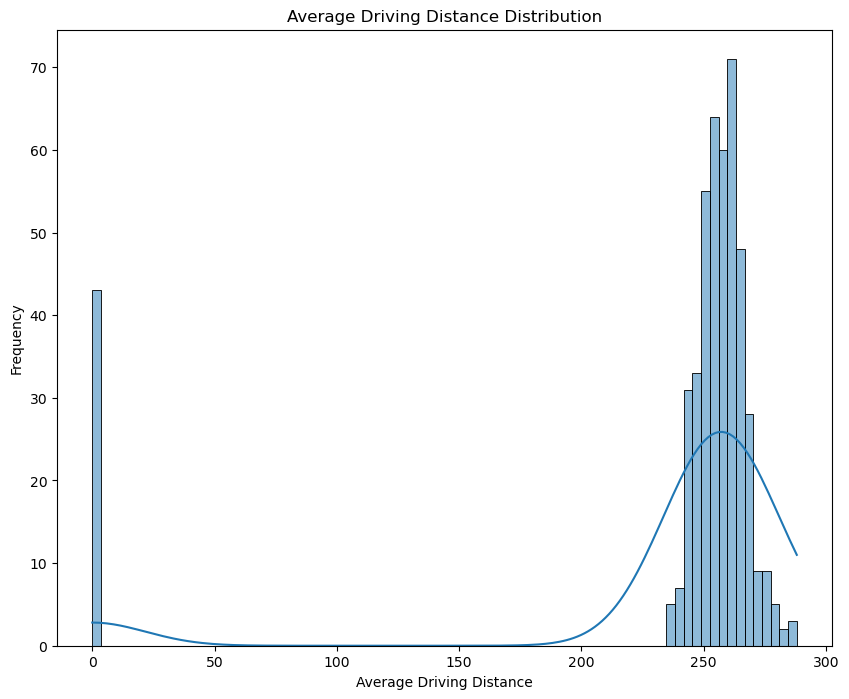

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.histplot(test['Average Driving Distance'], kde=True)
plt.title("Average Driving Distance Distribution")
plt.xlabel("Average Driving Distance")
plt.ylabel("Frequency")
plt.show()

### 50km 미만인 것은 프로선수로서, 말도 안된다. 잘못된 데이터라 생각해서, 해당 데이터는 제거하겠다.

In [105]:
test = test[test['Average Driving Distance'] >= 50]

print(test.shape)

(430, 21)


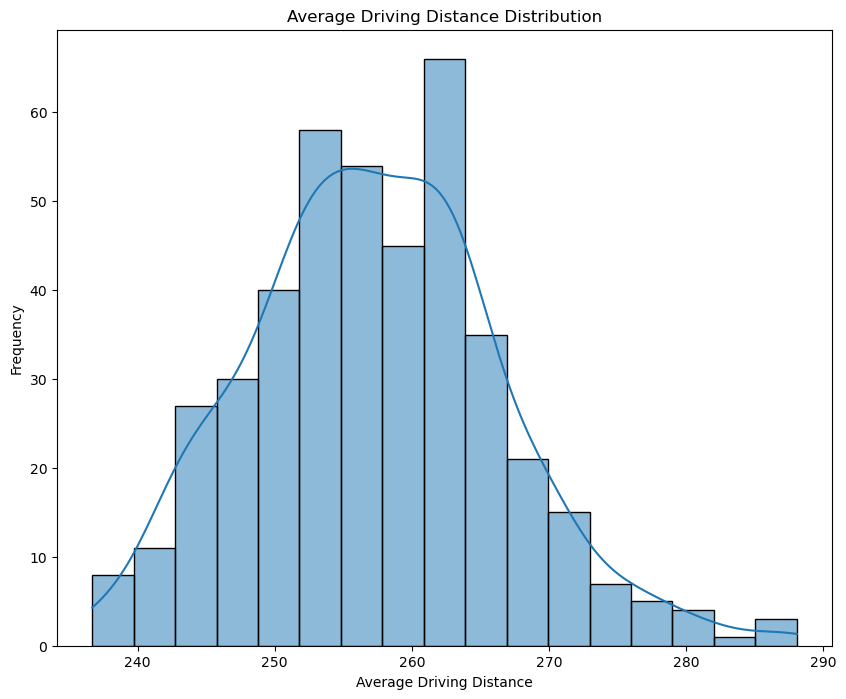

In [106]:
plt.figure(figsize=(10, 8))
sns.histplot(test['Average Driving Distance'], kde=True)
plt.title("Average Driving Distance Distribution")
plt.xlabel("Average Driving Distance")
plt.ylabel("Frequency")
plt.show()

### 순위권 밖에 있는 데이터가 몇개인지 세보자. 

In [110]:
# -가 하나라도 있는 행의 갯수를 세갰다.

count_dash_2022 = {}
count_dash_2023 = {}
count_dash_2024 = {}

test_2022 = test[test['Year'] == '2022']
test_2023 = test[test['Year'] == '2023']
test_2024 = test[test['Year'] == '2024']


for col in test.columns:
    if test[col].dtype == 'O':
        count = (test[col] == '-').sum()
        count_2022 = (test_2022[col] == '-').sum()  # 2022년의 '-'인 값의 개수 세기
        count_2023 = (test_2023[col] == '-').sum()  # 2023년의 '-'인 값의 개수 세기
        count_2024 = (test_2024[col] == '-').sum()
        
        count_dash_2022[col] = count_2022  # 2022년 결과 저장
        count_dash_2023[col] = count_2023  # 2023년 결과 저장
        count_dash_2024[col] = count_2024

print("2022년 '-' 값 개수:")
for col, count in count_dash_2022.items():
    print(f"{col}: {count}개의 '-' 값")

print("\n2023년 '-' 값 개수:")
for col, count in count_dash_2023.items():
    print(f"{col}: {count}개의 '-' 값")

print("\n2024년 '-' 값 개수:")
for col, count in count_dash_2024.items():
    print(f"{col}: {count}개의 '-' 값")


2022년 '-' 값 개수:
Country: 0개의 '-' 값
Player Name: 0개의 '-' 값
Average Driving Distance_rank: 17개의 '-' 값
Driving Accuracy_rank: 17개의 '-' 값
Greens in Regulation_rank: 17개의 '-' 값
Putts per GIR_rank: 17개의 '-' 값
Putting Average_rank: 17개의 '-' 값
Sand Saves_rank: 17개의 '-' 값
Scoring Average_rank: 17개의 '-' 값
Rounds Under Par_rank: 6개의 '-' 값
Total Rounds Played_rank: 0개의 '-' 값

2023년 '-' 값 개수:
Country: 0개의 '-' 값
Player Name: 0개의 '-' 값
Average Driving Distance_rank: 12개의 '-' 값
Driving Accuracy_rank: 12개의 '-' 값
Greens in Regulation_rank: 12개의 '-' 값
Putts per GIR_rank: 12개의 '-' 값
Putting Average_rank: 12개의 '-' 값
Sand Saves_rank: 12개의 '-' 값
Scoring Average_rank: 12개의 '-' 값
Rounds Under Par_rank: 5개의 '-' 값
Total Rounds Played_rank: 0개의 '-' 값

2024년 '-' 값 개수:
Country: 0개의 '-' 값
Player Name: 0개의 '-' 값
Average Driving Distance_rank: 0개의 '-' 값
Driving Accuracy_rank: 0개의 '-' 값
Greens in Regulation_rank: 0개의 '-' 값
Putts per GIR_rank: 0개의 '-' 값
Putting Average_rank: 0개의 '-' 값
Sand Saves_rank: 0개의 '-' 값
Scoring 

### 데이터 저장

In [111]:
save_path = "C:\\Users\\minsu\\Downloads\\golf_project\\lgpa_final_data.csv"

In [112]:
test.to_csv(save_path, index=False)

In [ ]:
##########################...................##################################

### Driving Accuracy (드라이빙 정확도)
- 파3홀을 제외하고, 파4, 파5홀에서 티샷이 페어웨이에 떨어진 것을 측정.

In [25]:
# 일괄적으로 함수를 적용하려 했으나, statistic에 따른 홈페이지 구조도가 다름


# 국가이름 추출
def extract_country_from_url(url):
    start_idx = url.find('countries/') + len('countries/')
    end_idx = url.rfind('.')
    return url[start_idx:end_idx]

# 1. Driving Accuracy (소수점 셋째자리 절삭)
def lgpa_da(statistic, category, year):
    url = f"https://www.lpga.com/statistics/{statistic}/{category}?year={year}"
    response = requests.get(url)
    if response.status_code != 200:
        print("사이트가 응답하지 않습니다.")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    tbody = soup.find('tbody')
    rows = tbody.find_all('tr', class_='body')
    
    data_list = []
    
    for row in rows:
        columns = row.find_all('td', class_='table-content')
        img_src = columns[1].find('img')['src']
        player_name = columns[1].text.strip()
        percentage = float(columns[4].text.strip().replace('%', '')) * 0.01
        percentage = int(percentage * 1000) / 1000
        
        country = extract_country_from_url(img_src)
        print(f"Country: {country}, Player Name: {player_name}, Percentage: {percentage}")
        
        data_list.append({
            'Country': country,
            'Year': year,
            'Player_name': player_name,
            'Driving_accuracy': percentage
        })
        
    da = pd.DataFrame(data_list)
    
    return da
        
        
    print(response)

In [26]:
years = ['2022', '2023', '2024']

statistic = 'driving'
categories = ['driving-accuracy']

temp = []

for year in years:
    for category in categories:
        print(f"Year: {year}, Category: {category}")
        df = lgpa_da(statistic, category, year)
        temp.append(df)
        print(df)
        print('-' * 50)

da_df = pd.concat(temp, ignore_index=True)
# lgpa_da('driving', 'driving-accuracy', '2022')

Year: 2022, Category: driving-accuracy
Country: usa, Player Name: Dana Fall, Percentage: 0.873
Country: usa, Player Name: Andrea Lee, Percentage: 0.868
Country: kor, Player Name: Inbee Park, Percentage: 0.859
Country: eng, Player Name: Charlotte Thomas, Percentage: 0.857
Country: usa, Player Name: Lizette Salas, Percentage: 0.854
Country: kor, Player Name: Chella Choi, Percentage: 0.85
Country: usa, Player Name: Stacy Lewis, Percentage: 0.848
Country: jpn, Player Name: Ayaka Furue, Percentage: 0.84
Country: tpe, Player Name: Vivian Hou, Percentage: 0.836
Country: usa, Player Name: Cheyenne Knight, Percentage: 0.834
Country: usa, Player Name: Megan Khang, Percentage: 0.833
Country: usa, Player Name: Marissa Steen, Percentage: 0.831
Country: usa, Player Name: Jaye Marie Green, Percentage: 0.828
Country: usa, Player Name: Caroline Inglis, Percentage: 0.828
Country: tpe, Player Name: Yu-Sang Hou, Percentage: 0.814
Country: usa, Player Name: Mina Harigae, Percentage: 0.812
Country: swe, Pla

In [27]:
da_df

,Country,Year,Player_name,Driving_accuracy
0,usa,2022,Dana Fall,0.873
1,usa,2022,Andrea Lee,0.868
2,kor,2022,Inbee Park,0.859
3,eng,2022,Charlotte Thomas,0.857
4,usa,2022,Lizette Salas,0.854
...,...,...,...,...
468,usa,2024,Auston Kim,0.576
469,mex,2024,Maria Fassi,0.560
470,chn,2024,Yan Liu,0.550
471,can,2024,Maude-Aimee Leblanc,0.515


### 2. Driving Distance (드라이빙 거리)
- 두 홀을 지정한 뒤, 골퍼가 지정된 파 4홀과 파 5홀에서 티샷을 친 평균 거리

In [ ]:
# 2. Driving Distance
def lgpa_dd(statistic, category, year):
    url = f"https://www.lpga.com/statistics/{statistic}/{category}?year={year}"
    response= requests.get(url)
    if response.status_code != 200:
        print("사이트가 응답하지 않습니다.")
        return None
    soup = BeautifulSoup(response.content, 'html.parser')
    
    tbody = soup.find('tbody')
    rows = tbody.find_all('tr', class_='body')
    
    data_list = []
    for row in rows:
        columns = row.find_all('td', class_='table-content')
        player_name = columns[1].text.strip()
        driving_distance = float(columns[2].text.strip())
        
        data_list.append({
            'Year': year,
            'Player_name': player_name,
            'Driving_distance': driving_distance
        })
    dd = pd.DataFrame(data_list)
    return dd

years = ['2022', '2023', '2024']

statistic = 'driving'
categories = ['average-driving-distance']

for year in years:
    for category in categories:
        print(f"Year: {year}, Category: {category}")
        
